In [1]:
import os
import tensorflow as tf
import glob
import pathlib
from tensorflow import keras
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
# from tensorflow.keras.applications import ResNet50
# from tensorflow.keras.applications.resnet50 import preprocess_input
# from tensorflow.keras.layers import Dense,Conv2D,Flatten

In [2]:
train="Vegetable Images/train"
test="Vegetable Images/test"
valid="Vegetable Images/validation"

In [3]:
len(os.listdir(train))

15

In [4]:
def process(data):
    path=pathlib.Path(data)#converting the dtring to path
    filepaths=list(path.glob(r"*/*.jpg"))#Going through all the subpaths 
    labels=list(map(lambda x: os.path.split(os.path.split(x)[0])[1],filepaths))#Separating the label from filepath and storing it
    df1=pd.Series(filepaths,name='filepaths').astype(str)
    df2=pd.Series(labels,name='labels')
    df=pd.concat([df1,df2],axis=1)#Making the dataframe
    return df

In [5]:
df_train=process(train)
df_test=process(test)
df_valid=process(valid)

In [6]:
df_test.head()

,filepaths,labels
0,Vegetable Images\test\Bean\0001.jpg,Bean
1,Vegetable Images\test\Bean\0002.jpg,Bean
2,Vegetable Images\test\Bean\0003.jpg,Bean
3,Vegetable Images\test\Bean\0004.jpg,Bean
4,Vegetable Images\test\Bean\0005.jpg,Bean


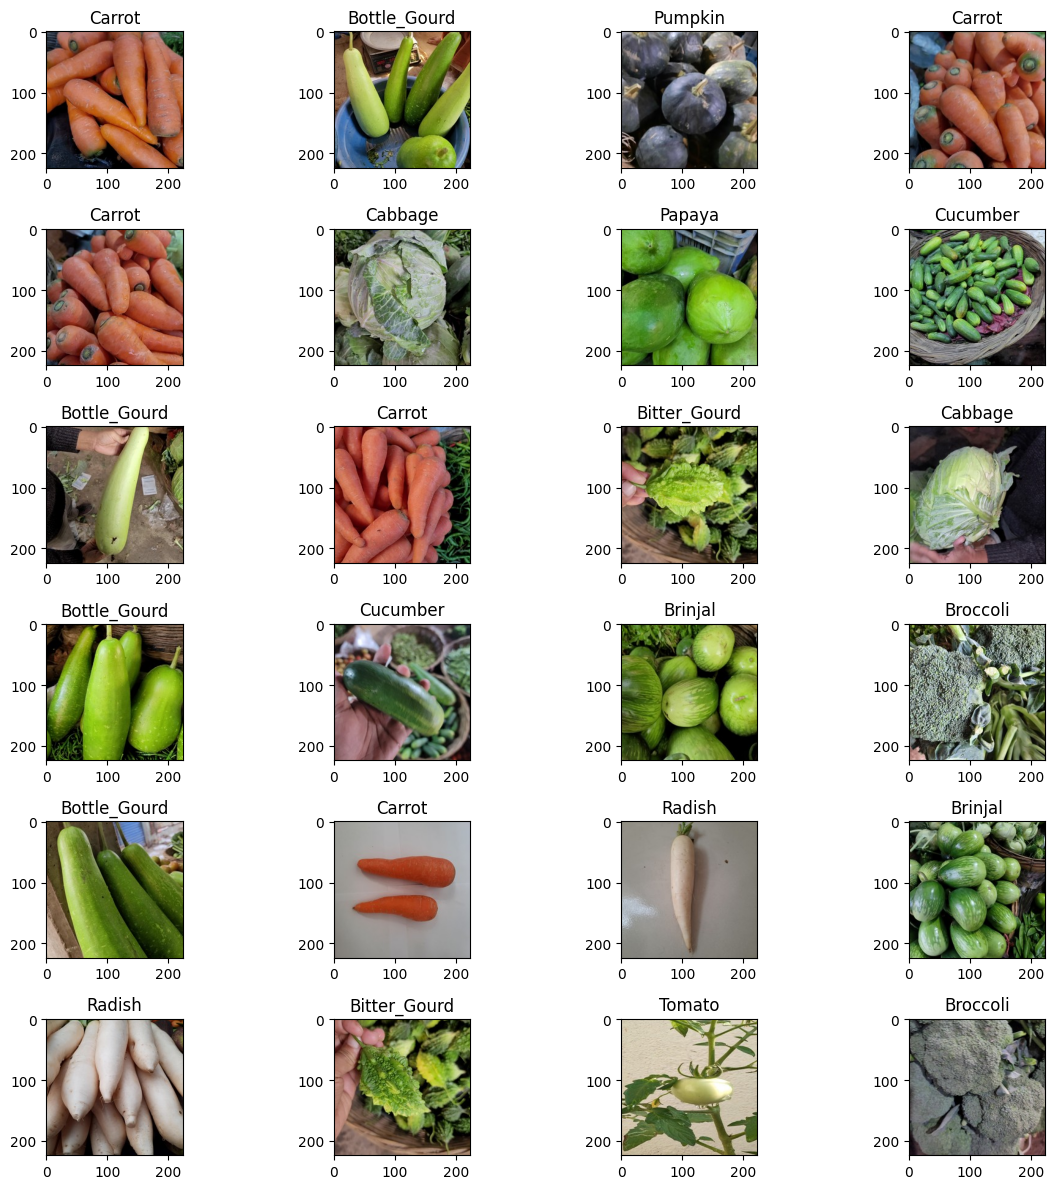

In [7]:
df_train=df_train.sample(frac=1).reset_index(drop=True)#Shuffling the dataframe so we can get random vegetable pictures
fig,axes=plt.subplots(nrows=6,ncols=4,figsize=(12,12))

for i,ax in enumerate(axes.flat):
    x=plt.imread(df_train['filepaths'][i])#reading the image
    ax.imshow(x)
    ax.set_title(df_train['labels'][i])
plt.tight_layout()    
plt.show()

In [8]:
train_generator=keras.preprocessing.image.ImageDataGenerator( preprocessing_function=keras.applications.resnet50.preprocess_input)
test_generator=keras.preprocessing.image.ImageDataGenerator( preprocessing_function=keras.applications.resnet50.preprocess_input)
valid_generator=keras.preprocessing.image.ImageDataGenerator( preprocessing_function=keras.applications.resnet50.preprocess_input)

In [9]:
train_image=train_generator.flow_from_dataframe(dataframe=df_train,
                                                x_col='filepaths',
                                                y_col='labels',
                                                target_size=(224,224),
                                                batch_size=16, #Altered for Hyperparameter Tuning
                                                subset='training',
                                                random_seed=42)

test_image = test_generator.flow_from_dataframe(
    dataframe=df_test,
    x_col='filepaths',
    y_col='labels',
    target_size=(224,224),
    batch_size=32
)

valid_image = test_generator.flow_from_dataframe(
    dataframe=df_valid,
    x_col='filepaths',
    y_col='labels',
    subset='training',
    target_size=(224,224),
    batch_size=32
)

Found 15000 validated image filenames belonging to 15 classes.
Found 3000 validated image filenames belonging to 15 classes.
Found 3000 validated image filenames belonging to 15 classes.


In [10]:
pretrained_model = keras.applications.ResNet50(
    input_shape=(224,224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False

In [11]:
inputs = pretrained_model.input

x = keras.layers.Dense(120, activation='relu')(pretrained_model.output)
x = keras.layers.Dense(120, activation='relu')(x)

outputs = keras.layers.Dense(15, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

In [12]:
model.compile(
    optimizer='adam', # Altered for Hyperparameter Tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [13]:
TrainedModel=model.fit(train_image,validation_data=valid_image,epochs=3)

Epoch 1/3
938/938 [==============================] - 1029s 1s/step - loss: 0.0793 - accuracy: 0.9787 - val_loss: 0.0177 - val_accuracy: 0.9950
Epoch 2/3
938/938 [==============================] - 924s 985ms/step - loss: 0.0170 - accuracy: 0.9954 - val_loss: 0.0018 - val_accuracy: 0.9997
Epoch 3/3
938/938 [==============================] - 740s 789ms/step - loss: 0.0144 - accuracy: 0.9958 - val_loss: 0.0088 - val_accuracy: 0.9970


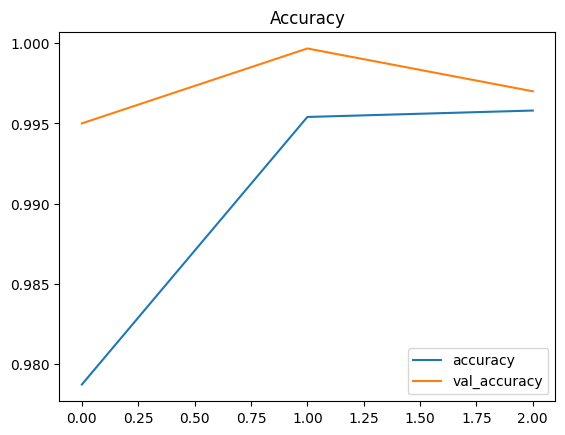

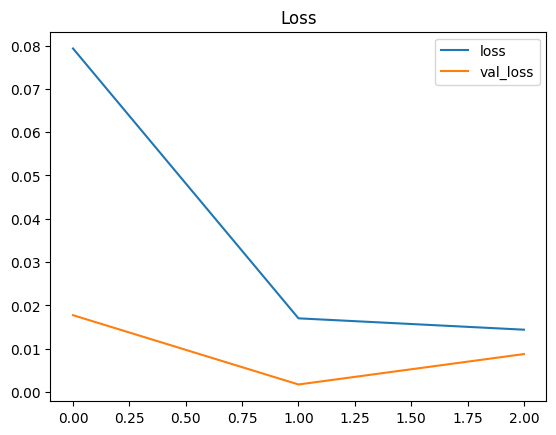

In [15]:
pd.DataFrame(TrainedModel.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()
pd.DataFrame(TrainedModel.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [20]:
model.save("/Recipe_Generator/resnet50.h5")

d:\Recipe_Generator\recgen\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [22]:
df_test.head()

,filepaths,labels
0,Vegetable Images\test\Bean\0001.jpg,Bean
1,Vegetable Images\test\Bean\0002.jpg,Bean
2,Vegetable Images\test\Bean\0003.jpg,Bean
3,Vegetable Images\test\Bean\0004.jpg,Bean
4,Vegetable Images\test\Bean\0005.jpg,Bean
